# Assignment 2 - part b

In [1]:
from networkx.readwrite import json_graph
import json
import networkx as nx
import pandas as pd
import numpy as np

In [2]:
# Load super network
with open(f"supernetwork.json", "r") as infile:
    json_data = json.load(infile)
    G_superhero = json_graph.adjacency_graph(json_data)

In [3]:
# Get the largest component
superhero_subgraphs = [G_superhero.subgraph(
    c).copy() for c in nx.weakly_connected_components(G_superhero)]
GC_superhero = max(superhero_subgraphs, key=len)

In [4]:
# Create the undirected graph
GC_super_un = GC_superhero.to_undirected()

## Communities

### Task:  Identify the communities in one or both of the superhero universes (DC/Marvel) as described in Week 7.

In [5]:
# Build a strictly marvel based network..
marvel_nodes = (node for node, data in GC_super_un.nodes(data=True) if data.get("universe") == "marvel")
G_marvel_un = GC_super_un.subgraph(marvel_nodes)

In [6]:
import community

# Identify communities in the Marvel universe using the Louvian algorithm
partition_marvel = community.best_partition(G_marvel_un)

### Task: Visualize the communities by coloring the graph's nodes according to community affiliation - also as described in Week 7.

100%|██████████| 500/500 [00:06<00:00, 71.84it/s]


BarnesHut Approximation  took  1.98  seconds
Repulsion forces  took  4.49  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.09  seconds
AdjustSpeedAndApplyForces step  took  0.15  seconds


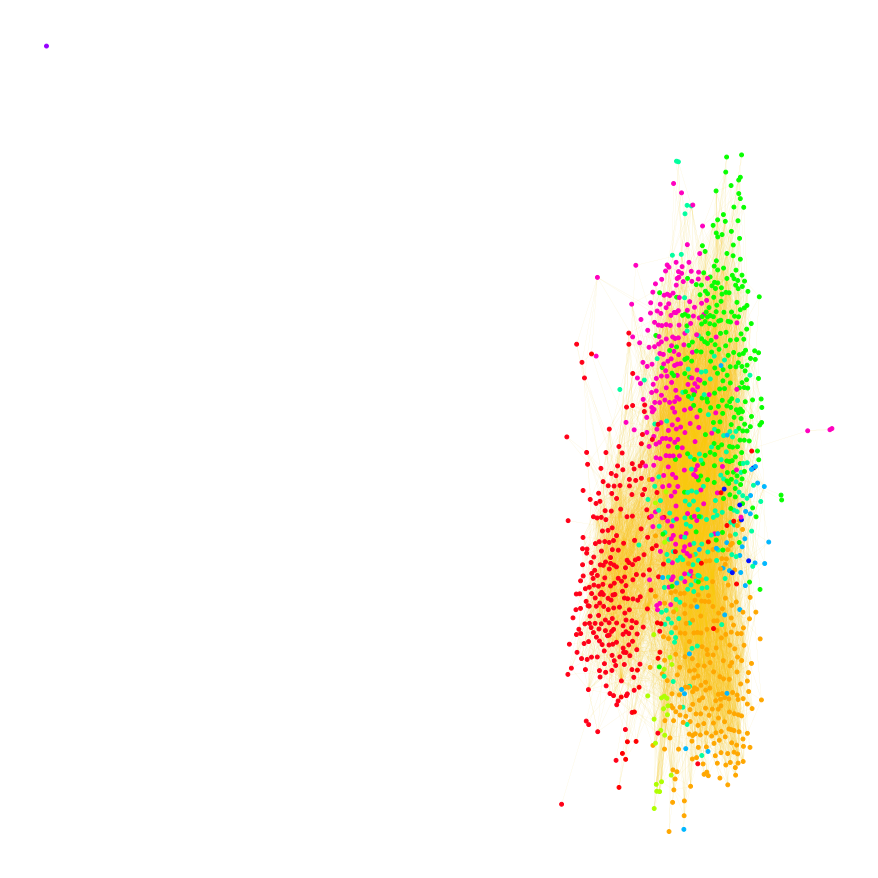

In [7]:
from fa2 import ForceAtlas2
import matplotlib.cm as cm
import matplotlib.pyplot as plt

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=0.1,
                        strongGravityMode=True,
                        gravity=5,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G_marvel_un, pos=None, iterations=500)

plt.figure(figsize=(12, 12))
# color the nodes according to their partition
cmap = cm.get_cmap('hsv', max(partition_marvel.values()) + 1)
nx.draw(G_marvel_un, pos=positions, with_labels=False, node_size=15, width=0.05, 
        cmap=cmap, node_color=list(partition_marvel.values()), edge_color='#f9c80e')
plt.show()

### Write a paragraph about your work to identify the communities. The paragraph should include

* Information about the algorithm you used to find communities.
* The value of modularity for your network.
* The number of communities and their sizes (in terms of number of nodes).

* Information about the algorithm you used to find communities.

For the community detection we are using the Louvain Algorithm. The algorithm, like many other community algorithms, is based on optimizing the modularity of the network. Modularity is a relative score from -0.5 to 1 that indicate how densely connected a number of nodes are linked together, relative to the expected number of links of a similar degree distributed random graph. A modularity higher than 0, indicate that a given group of nodes are more connected that one would expect if it was random, and therefor has the potential to represent a community. A combined modularity score of the graph can be found by adding and averaging over all detected communities, and the assumption is, that maximizing M over the entire graph provide the best parition of communities. 

The Louvains algorithm optimize for the highest modularity score in two repeated steps, after initiallity splittng the graph and assuming that each node belongs to its own community:
- 1: For each node, evaluate the gain in modularity if the node is placed in a communiy with one of its neigbhors, join the node where the modularity gain is maximized, and if non is gained, stay in the original community. Run untill no further improvements can be achieved.
- 2: Construct a new network where each node are the communities from step1, and the weight of the links between two nodes (that consist a number of nodes) are the sum of the links in the corresponding community. 

Step 1-2 is repeated untill no gain in maximum modularity is attained.

Like other algorithms based on modularity maximuzation, this approach "suffer" from the simplification that no node can be part of two communities, which in reality often is the case. An alternative approach would be to generate communities based on link clustering that allow nodes to be part of several communities.

* The value of modularity for your network.

The Marvel network has a modularity of 0.38 indicating the pressence of communities. 

In [8]:
# Get lists of partitions
partition_list_marvel = {}
for pair in partition_marvel.items():
    if pair[1] not in partition_list_marvel.keys():
        partition_list_marvel[pair[1]] = []

    partition_list_marvel[pair[1]].append(pair[0])

In [9]:
from networkx.algorithms.community.quality import modularity

# Calculate the modularity
modularity(G_marvel_un, partition_list_marvel.values())

0.37862238617696314

* The number of communities and their sizes (in terms of number of nodes).

A total of 10 communities were detected in the Marvel universe
Community 8 has 231 nodes
Community 1 has 225 nodes
Community 3 has 257 nodes
Community 4 has 139 nodes
Community 9 has 248 nodes
Community 0 has 23 nodes
Community 5 has 35 nodes
Community 2 has 25 nodes
Community 6 has 6 nodes
Community 7 has 1 nodes


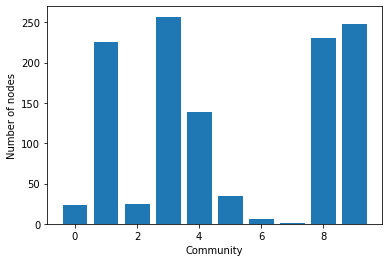

In [10]:
#number of communities detected
print(f'A total of {len(partition_list_marvel.keys())} communities were detected in the Marvel universe')
for comm in partition_list_marvel.keys():
    #sorted according to number of nodes
    print(f"Community {comm} has {len(partition_list_marvel[comm])} nodes")


import matplotlib.pyplot as plt
#plot bar chart of each community and the number of nodes in it sorted according to number of nodes in each community:
sorted_communities = sorted(partition_list_marvel.items(), key=lambda x: len(x[1]), reverse=True)
plt.bar([x[0] for x in sorted_communities], [len(x[1]) for x in sorted_communities])
plt.xlabel('Community')
plt.ylabel('Number of nodes')
plt.show()

The number of communities detected vary as the algorithm is run , but typically result in a total of 9-11 commmunities. A few large communities, typically with +200 nodes, make up a large proportion of the network. As seen from the commulitative plot below, roughly 90% of all nodes are included in the 5 largest communities. The remaining commmunities held a smaller number of nodes, typically 10-50, and a single community of just 1 node.

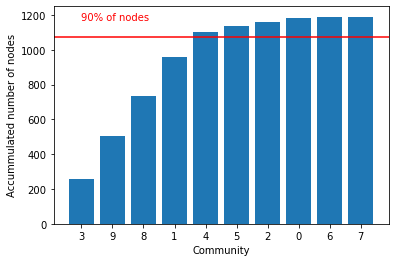

In [11]:
#plot a bar chart with the accumulated number of nodes in each community sorted according to number of nodes in each community:

plt.bar(([str(x[0]) for x in sorted_communities]), [sum([len(x[1]) for x in sorted_communities[:i+1]]) for i in range(len(sorted_communities))])
plt.xlabel('Community')
plt.ylabel('Accummulated number of nodes')
#add threshold at 90% of the total number of nodes
plt.axhline(y=0.9*len(G_marvel_un.nodes()), color='r', linestyle='-')
#add text at the threshold
plt.text(0, 0.9*len(G_marvel_un.nodes())+100, '90% of nodes', color='red')
plt.show()

### Task: For the 10 largest communities, process the text in order to create a TF-IDF vector for each community. Explain in your own words how TF-IDF works.

We start by getting the pickle file of all the heroes

In [12]:
df_superhero = pd.read_pickle('df_superhero_pkl.pkl')
df_superhero.head()

,Unnamed: 0,CharacterName,WikiLink,file,universe,WikiOutLinks,TextLen
0,0,Abin Sur,[Abin Sur],Abin_Sur.json,dc,"[Special:ApiFeatureUsage, DC Comics, John Broo...",5351
1,1,Abra Kadabra (character),[Abra Kadabra (character)],Abra_Kadabra_%28character%29.json,dc,"[Special:ApiFeatureUsage, Oscar Jimenez (comic...",2740
2,2,Abby Holland,[Abby Holland],Abby_Holland.json,dc,"[Special:ApiFeatureUsage, File:SwampThing22.jp...",4446
3,3,Ace the Bat-Hound,[Ace the Bat-Hound],Ace_the_Bat-Hound.json,dc,"[Special:ApiFeatureUsage, Detective Comics, 20...",3294
6,6,Adam Strange,[Adam Strange],Adam_Strange.json,dc,"[Special:ApiFeatureUsage, Alex Ross, DC Comics...",7533


Then we get the pickle file of the Marvel universe only

In [13]:
df_marvel = df_superhero[df_superhero['universe'] == 'marvel']

#### We can then get the 10 largest communities from the sorted community list

In [14]:
sorted_communities = sorted_communities[:10]

Now we iterate over the heroes from each community to find their related files and save the wikitexts as one string for each community.

In [15]:
community_text = {}

#Iterate over each community
for comm_list in sorted_communities:
    #create a item in the dict with key = community number, and value = empty string
    community_text[comm_list[0]] = ''
    #iterate through each node in the community
    for node in comm_list[1]:
        #to identify the associated filename and append wikitext, iterate through the dataframe
        for wikilink, file in zip(df_marvel.WikiLink, df_marvel.file):
        #match the node name with wikilink, and add the text of the node using the file-name association and json loads
            if node == wikilink[0]:
                    with open(f"../wikidata/{file}", "r") as infile:
                        jsonwiki = json.load(infile)
                        #converts the json to a string
                        text_content = str(jsonwiki['query']['pages'])
                        for page in jsonwiki['query']['pages']:
                            #page id -1 occur when an empty page is returned
                            if page != '-1': 
                                #extracts the text from the json
                                text_content = jsonwiki['query']['pages'][page]['revisions'][0]['*']
                                #appends the text to the community text
                                community_text[comm_list[0]] += str(text_content)
                        

community_text.keys()

dict_keys([3, 9, 8, 1, 4, 5, 2, 0, 6, 7])

Then we tokenize the texts to be able to work with the text word for word.

In [16]:
import nltk
from nltk.tokenize import word_tokenize

# Tokenize the community text
for comm in community_text.keys():
    community_text[comm] = word_tokenize(community_text[comm])

#### We can now calculate the TF of each word in each community.

In [17]:
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()


#             ----- OBS ------
#Require the omw-1.4 corpora, which can be downloaded using nltk.download() and selecting the omw-1.4 corpus under the "Corpora" tab
#nltk.download()

#To acurately apply lemmetaizer the POS tag (noun, adjective. etc) must be provided, otherwise as per defalt a word like "was" is shortened to "wa"
#the POS tag of each word us obtained using the pre-trained POS tag module of the NLTK library
#nltk.pos_tag returns a tuple with the word and the POS tag
#However, the returned tag format (NN, NNP, JJ etc.) is not the expected abreviation that the Wordnet lemmetizer function expects (V, J, N etc.)

#In order to make the returned value of the POS tag directly applicable with the lemmaziner, a function is written to map the get_POS function to the wordnet "POS format"

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        # As default pos in lemmatization is Noun
        return wordnet.NOUN


#Took me 5 minutes to run the lemmatizer on the whole dataset

community_text_lem = {}
for comm in community_text.keys():
    lemmatized_words = []
    tagged_comm = nltk.pos_tag(community_text[comm])
    for word, tag in tagged_comm:
        wntag = get_wordnet_pos(tag)
        lemmatized_words.append(lemmatizer.lemmatize(word, pos=wntag))
    community_text_lem[comm] = lemmatized_words
    #the below way of doing it, for some reason, takes 10x longer to run. Don't do that...
    #community_text_lem[comm] = [wnl.lemmatize(word,pos=get_wordnet_pos(nltk.pos_tag([word])[0][1])) for word in community_text[comm]]


In [18]:
#making sure lemmatizing didn't mess up things...
print(f'text len before lemmatizing {len(community_text[5])} ')
print(f'text len after lemmatizing {len(community_text_lem[5])} ')

text len before lemmatizing 100682 
text len after lemmatizing 100682 


In [19]:
#filter off stopwords
stopwords = nltk.corpus.stopwords.words('english')
#As it turns out, the word "ref", and 'category' are amongst the most used across all our wikipedia 
#because these are part of the wikitext structure, to filter theese we add them to the exception list
stopwords.append('ref')
stopwords.append('category')

freqDist = {}

# Calculate the frequency distribution of the words in each community
#only process words, and consider all words as lower-case
for comm in community_text_lem.keys():
    freqDist[comm] = nltk.FreqDist(word.lower() for word in community_text_lem[comm] if word.isalpha() and word.lower() not in stopwords)

In [20]:
# Get the top 5 words in each community
for comm in sorted(freqDist.keys()):
    print(f'Community {comm} top 5 words: {freqDist[comm].most_common(5)}')


Community 0 top 5 words: [('marvel', 674), ('flight', 479), ('comic', 448), ('comics', 325), ('character', 322)]
Community 1 top 5 words: [('marvel', 9301), ('comic', 5034), ('comics', 4450), ('character', 4235), ('cite', 3373)]
Community 2 top 5 words: [('marvel', 1404), ('comic', 756), ('runaways', 633), ('nico', 581), ('pride', 548)]
Community 3 top 5 words: [('marvel', 10737), ('comic', 5337), ('comics', 4800), ('character', 3606), ('cite', 3553)]
Community 4 top 5 words: [('marvel', 5663), ('comic', 3086), ('comics', 2926), ('character', 2289), ('cite', 2064)]
Community 5 top 5 words: [('marvel', 805), ('comic', 598), ('comics', 485), ('new', 450), ('warriors', 401)]
Community 6 top 5 words: [('doom', 113), ('marvel', 111), ('comics', 56), ('comic', 52), ('character', 49)]
Community 7 top 5 words: [('tarzan', 178), ('comics', 92), ('br', 62), ('http', 60), ('comic', 56)]
Community 8 top 5 words: [('marvel', 8147), ('comic', 4758), ('man', 3914), ('comics', 3910), ('avengers', 3273

In [21]:
from nltk.text import Text
#Inspect in what context certain words are used using the concordance function from nltk
commmunity_text_test = Text(community_text[6])
commmunity_text_test .concordance('kung')

no matches


Then we can print the top 5 words of each of the 10 largest communities.

## Calculating IDF - Jesper version

In [22]:
#The inverse document frequency (IDF) deterimes how important a term (word) is, relative to a corpus of documents. Since our purpose is to figure out what charactarizes the communities
#within the marvel universe. We therefore decide to let "the corpus of N documents" refer to corpus = all communities, and a document to a community. 

#... I wanted to do it by looking at the number of character documents that contain the word, but I couldn't figure out how to do it in a reasonable amount of time....

#This way we expect our TD-IDF to be able to determine what words are most distinctive for a given community, in the context of a marvel universe (hence omitting words like "marvel", "character", "comic", etc.))

idf = {}

for comm in freqDist.keys():
    #for each community (number)
    for word in freqDist[comm].keys():
        #if the word has not been IDF scored yet
        if word not in idf.keys():
            for freq_dict in freqDist.values():
                if word in freq_dict.keys():
                    #if the word is in the frequency dict of a given community, 1 to the IDF score
                    if word not in idf.keys():
                        idf[word] = 1
                    else:
                        idf[word] += 1
            #Divide the total number of communities ("documents ") with the number of communities in which the word appeared
            idf[word] = len(freqDist.keys())/ idf[word]
            idf[word] = np.log2(idf[word])

print('We would expect that the word marvel carry no weight as it is present in every community: the IDF score is: ', idf['marvel'])
print('We would expect that the word Kung carry some weight as it seems like a rather community specific word: the IDF score is:', idf['kung'])
#idf[word] = np.log2(len(freqDist[comm].keys()) / freqDist[comm][word])

We would expect that the word marvel carry no weight as it is present in every community: the IDF score is:  0.0
We would expect that the word Kung carry some weight as it seems like a rather community specific word: the IDF score is: 0.5145731728297582


In [23]:
#Calculate the Term Frequency - TF - simply by dividing the raw frequency count with the total number of words in a given text
#This is done to make the TF-IDF score independent of the size of the community
for comm in freqDist.keys():
    for word in freqDist[comm].keys():
        freqDist[comm][word] = freqDist[comm][word]/len(community_text_lem[comm])


In [24]:
tf_idf = {}

for comm in freqDist.keys():
    tf_idf[comm] = {}
    for word in freqDist[comm].keys():
        tf_idf[comm][word] = freqDist[comm][word] * idf[word]

#### We can then calculate IDF for every word in every list

In [25]:
# Calculate the inverse document frequency (IDF) by taking the logarithm (base 2) of the inverse frequency of the word in each community
idf = {}

for comm in freqDist.keys():
    idf[comm] = {}
    for word in freqDist[comm].keys():
        idf[comm][word] = np.log2(len(freqDist[comm].keys()) / freqDist[comm][word])

In [26]:
# Get the top 5 words in each community according to IDF
for comm in sorted(idf.keys()):
    print(f'Community {comm} top 5 words according to IDF: {sorted(idf[comm].items(), key=lambda x: x[1], reverse=True)[:5]}')

Community 0 top 5 words according to IDF: [('marc', 28.78647231843325), ('silvestri', 28.78647231843325), ('renowned', 28.78647231843325), ('packers', 28.78647231843325), ('metamorphosis', 28.78647231843325)]
Community 1 top 5 words according to IDF: [('consensus', 34.323163426125205), ('crouch', 34.323163426125205), ('webhead', 34.323163426125205), ('inadequacy', 34.323163426125205), ('hopkins', 34.323163426125205)]
Community 2 top 5 words according to IDF: [('evolution', 30.046815007307682), ('clockwise', 30.046815007307682), ('ross', 30.046815007307682), ('colleague', 30.046815007307682), ('product', 30.046815007307682)]
Community 3 top 5 words according to IDF: [('rabum', 34.274499203402215), ('alal', 34.274499203402215), ('hassenstadt', 34.274499203402215), ('maleficium', 34.274499203402215), ('technopathy', 34.274499203402215)]
Community 4 top 5 words according to IDF: [('hatnote', 33.13275053743633), ('strangelove', 33.13275053743633), ('egotistically', 33.13275053743633), ('pro

In [27]:
# The TF-IDF is the product of the term frequency and the inverse document frequency
tf_idf = {}

for comm in freqDist.keys():
    tf_idf[comm] = {}
    for word in freqDist[comm].keys():
        tf_idf[comm][word] = freqDist[comm][word] * idf[comm][word]

In [28]:
# List the top 10 words in each community according to TF-IDF
for comm in sorted(tf_idf.keys()):
    print(f'Community {comm} top 10 words according to TF-IDF: {sorted(tf_idf[comm].items(), key=lambda x: x[1], reverse=True)[:10]}')

Community 0 top 10 words according to TF-IDF: [('marvel', 0.1452489104763261), ('flight', 0.10584896734006), ('comic', 0.09947923971743584), ('comics', 0.0738394813383514), ('character', 0.07320576662164602), ('cite', 0.07172534875814929), ('alpha', 0.0600018579761628), ('fu', 0.05288027462816683), ('kung', 0.04171780120215714), ('master', 0.03994685215304201)]
Community 1 top 10 words according to TF-IDF: [('marvel', 0.1669260914340101), ('comic', 0.09413088707346509), ('comics', 0.08388274388338547), ('character', 0.08008684717614782), ('cite', 0.06472600832354067), ('peter', 0.054150613370140974), ('amazing', 0.047587940832637274), ('appear', 0.04493779011938211), ('new', 0.044716451880635215), ('vol', 0.03930558802917719)]
Community 2 top 10 words according to TF-IDF: [('marvel', 0.15331015931016784), ('comic', 0.08631476879455946), ('runaways', 0.07317532257376737), ('nico', 0.06756454739471585), ('pride', 0.06398464494748123), ('comics', 0.059186396396323164), ('cite', 0.05270332

### Task: Then visualize the TF-IDF vectors using wordclouds (as described in Week 7). Remember to comment on your word-clouds (e.g. in the figure captions): Do the wordclouds/TF-IDF lists enable you to understand the communities you have found (or is it just gibberish)? Justify your answer.

In [29]:
# Combine the TF-IDF values of all communities into a single string
community_strings = {}

for comm in tf_idf.keys():
    community_strings[comm] = ' '.join([word for word in tf_idf[comm].keys()])

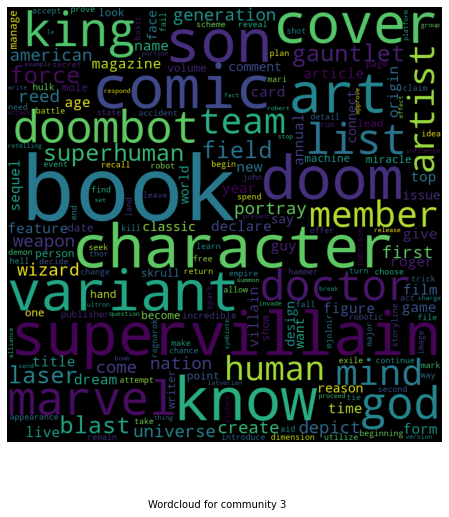

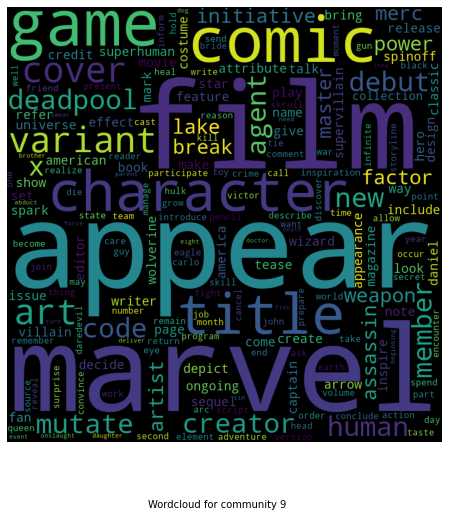

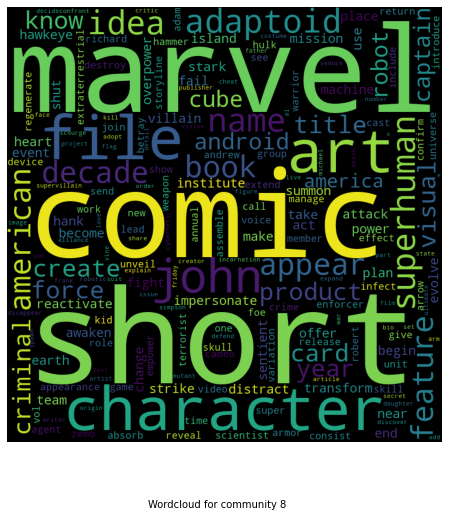

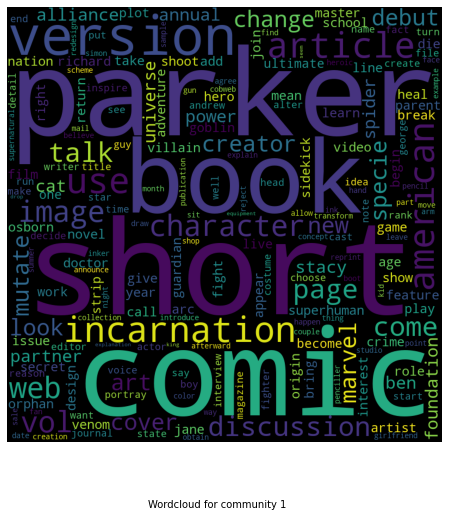

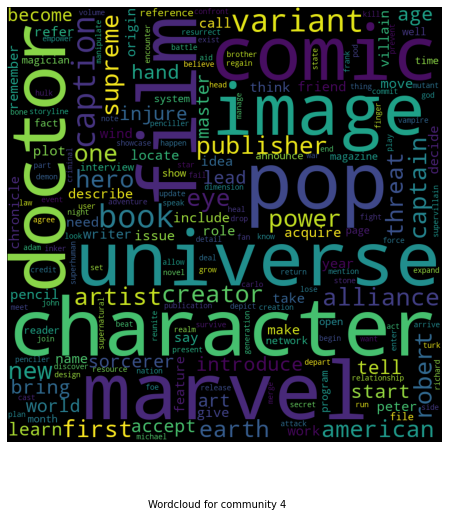

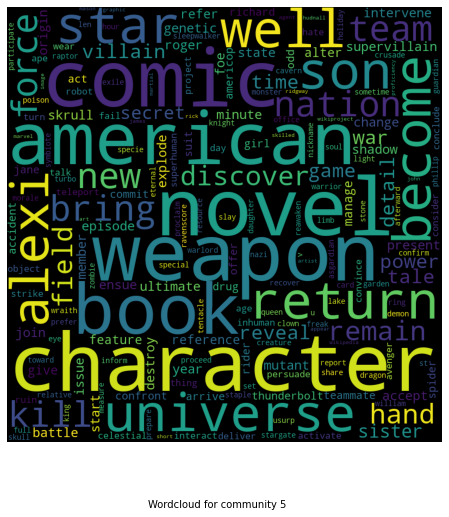

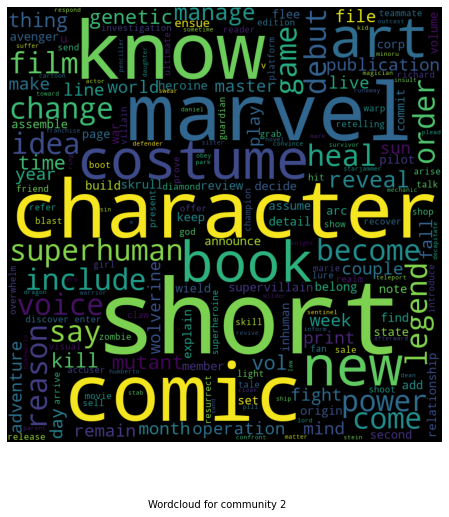

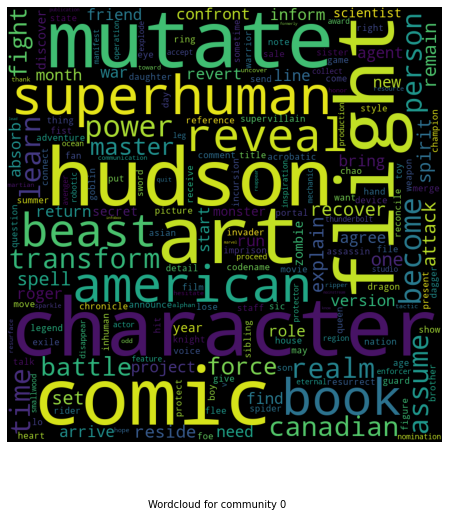

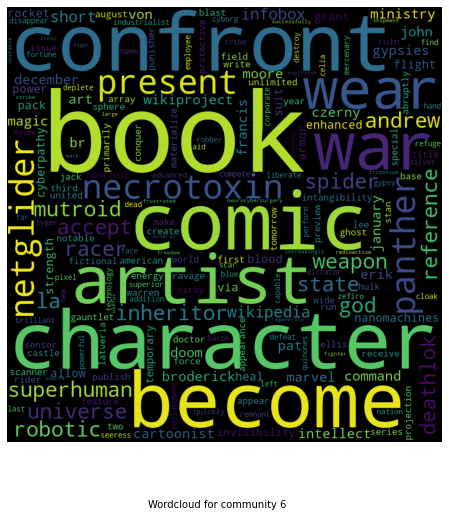

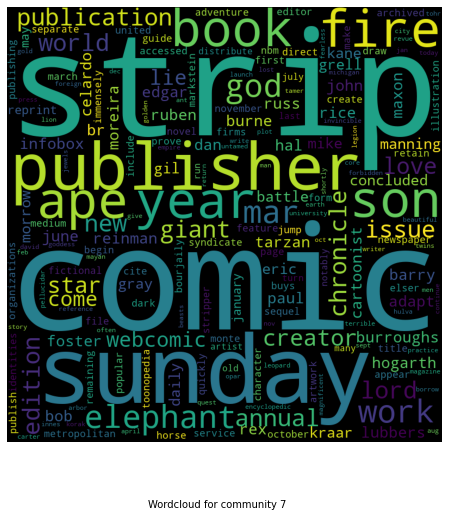

In [30]:
# Create a word cloud for each community
from wordcloud import WordCloud, STOPWORDS

for comm in community_strings.keys():
    wordcloud = WordCloud(
                width = 800, 
                height = 800,
                background_color ='black',
                stopwords = STOPWORDS
                ).generate(community_strings[comm])
    fig = plt.figure(figsize = (8, 8))
    plt.imshow(wordcloud)
    plt.axis("off")
    fig.text(.5, .01, f'Wordcloud for community {comm}', ha='center')
    plt.show()